STRATEGY 2: TREND BASED

HERE IS THE CODE FOR NIFTY 50 FOR 15 MIN TIMEFRAME

In [1]:
import pandas as pd
import numpy as np
from datetime import time

In [2]:
# LOAD AND PREPARE OF DATA
df = pd.read_csv('datasets/NF_15.csv')
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"])
df = df.sort_values("datetime").reset_index(drop=True)
df.head()

,date,time,open,high,low,close,volume,datetime
0,2020-01-01,09:15:00,12202.15,12222.05,12201.45,12221.65,0,2020-01-01 09:15:00
1,2020-01-01,09:30:00,12221.35,12221.90,12197.35,12203.15,0,2020-01-01 09:30:00
2,2020-01-01,09:45:00,12203.00,12205.00,12191.45,12200.50,0,2020-01-01 09:45:00
3,2020-01-01,10:00:00,12200.65,12201.20,12184.80,12190.85,0,2020-01-01 10:00:00
4,2020-01-01,10:15:00,12190.85,12200.45,12187.40,12197.75,0,2020-01-01 10:15:00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31638 entries, 0 to 31637
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      31638 non-null  object        
 1   time      31638 non-null  object        
 2   open      31638 non-null  float64       
 3   high      31638 non-null  float64       
 4   low       31638 non-null  float64       
 5   close     31638 non-null  float64       
 6   volume    31638 non-null  int64         
 7   datetime  31638 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.9+ MB


In [4]:
# CALCULATING TRADITIONAL RENKO
brick_size = 10
df['renko'] = df['close'].copy()

# Create Renko bricks
renko = [df['close'][0]]
for i in range(1, len(df)):
    price_diff = df['close'][i] - renko[-1]
    if abs(price_diff) >= brick_size:
        brick_count = int(price_diff / brick_size)
        renko.extend([renko[-1] + brick_count * brick_size] * abs(brick_count))

df['renko'] = renko[:len(df)]

CALCULATING INDICATORS 

In [5]:
# EMA Indicators
df["EMA_9"] = df["renko"].ewm(span=9, adjust=False).mean()
df["EMA_20"] = df["renko"].ewm(span=20, adjust=False).mean()

from ta.momentum import RSIIndicator

# RSI Calculation (using 14-period RSI)
rsi_indicator = RSIIndicator(close=df['renko'], window=14)
df['rsi'] = rsi_indicator.rsi()

In [6]:
# TRADING PARAMETERS
target = 300
stoploss = 50
slippage_pct = 0.0001  # 0.01%
position = None
entry_price = 0
entry_time = None
trades = []
lot_size = 75

In [7]:
# BACKTESTING THE TRADE
for i in range(len(df)):
    row = df.iloc[i]
    price = row["renko"]

    # Entry
    if position is None:
        if row["EMA_9"] > row["EMA_20"] and row["rsi"] > 60:
            position = "long"
            entry_price = price * (1 + slippage_pct)
            entry_time = row["datetime"]
        elif row["EMA_9"] < row["EMA_20"]:
            position = "short"
            entry_price = price * (1 - slippage_pct)
            entry_time = row["datetime"]

    # Exit
    if position == "long":
        if price <= entry_price - stoploss or price >= entry_price + target \
           or not (row["EMA_9"] > row["EMA_20"]):
            exit_price = price * (1 - slippage_pct)
            trades.append({
                "type": "long",
                "entry_price": entry_price,
                "exit_price": exit_price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

    elif position == "short":
        if price >= entry_price + stoploss or price <= entry_price - target \
           or not (row["EMA_9"] < row["EMA_20"]):
            exit_price = price * (1 + slippage_pct)
            trades.append({
                "type": "short",
                "entry_price": entry_price,
                "exit_price": exit_price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

# Trade Analysis
trades_df = pd.DataFrame(trades)

# PnL
trades_df["pnl"] = np.where(
    trades_df["type"] == "long",
    trades_df["exit_price"] - trades_df["entry_price"],
    trades_df["entry_price"] - trades_df["exit_price"]
)

In [13]:
# CAPITAL 
initial_capital = 1e6
leverage = 5
position_size = 75

trades_df["pnl_amount"] = trades_df["pnl"] * position_size * leverage
trades_df["equity"] = initial_capital + trades_df["pnl_amount"].cumsum()


In [14]:
# METRICS CALCULATION
total_pnl = trades_df['pnl_amount'].sum()
returns = trades_df['pnl_amount'] / initial_capital
risk_free_rate = 0.06
annualized_return = returns.mean() * 252
annualized_volatility = returns.std() * np.sqrt(252)
sharpe = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else 0

# Max Drawdown
equity = trades_df['pnl_amount'].cumsum()
roll_max = equity.cummax()
drawdown = roll_max - equity
max_dd = drawdown.max() if not drawdown.empty else 1

# Drawdown Duration
drawdown_start = None
max_drawdown_duration = 0
current_duration = 0
for i in range(len(drawdown)):
    if drawdown.iloc[i] > 0:
        current_duration += 1
        if current_duration > max_drawdown_duration:
            max_drawdown_duration = current_duration
    else:
        current_duration = 0

# Calmar Ratio
capital = initial_capital
start_date = pd.to_datetime(trades_df['entry_time']).min()
end_date = pd.to_datetime(trades_df['entry_time']).max()
days = (end_date - start_date).days or 1
annual_return = (total_pnl / capital) * (365 / days)
max_dd_pct = max_dd / capital if capital != 0 else 0
calmar = annual_return / max_dd_pct if max_dd_pct != 0 else 0

# Other Metrics
num_wins = trades_df[trades_df['pnl'] > 0].shape[0]
num_losses = trades_df[trades_df['pnl'] <= 0].shape[0]
win_rate = num_wins / len(trades_df) if len(trades_df) > 0 else 0
profit_factor = trades_df[trades_df['pnl'] > 0]['pnl'].sum() / abs(trades_df[trades_df['pnl'] <= 0]['pnl'].sum()) if num_losses > 0 else float('inf')


In [15]:
# PRINTING METRICS
print("=== Strategy Performance Metrics (Renko + EMA Cross + Slippage) ===")
print(f"Initial Capital     : ₹{initial_capital:,.0f}")
print(f"Effective Capital   : ₹{initial_capital * leverage:,.0f}")
print(f"Total PnL           : ₹{total_pnl:,.0f}")
print(f"Sharpe Ratio        : {sharpe:.2f}")
print(f"Max Drawdown        : ₹{max_dd:,.0f}")
print(f"Max Drawdown Duration: {max_drawdown_duration} days")
print(f"Calmar Ratio        : {calmar:.2f}")
print(f"Win Rate            : {win_rate:.2%}")
print(f"Profit Factor       : {profit_factor:.2f}")

=== Strategy Performance Metrics (Renko + EMA Cross + Slippage) ===
Initial Capital     : ₹1,000,000
Effective Capital   : ₹5,000,000
Total PnL           : ₹9,186,786
Sharpe Ratio        : 2.22
Max Drawdown        : ₹441,363
Max Drawdown Duration: 111 days
Calmar Ratio        : 4.08
Win Rate            : 36.07%
Profit Factor       : 1.55


PLOTTING THE CURVE

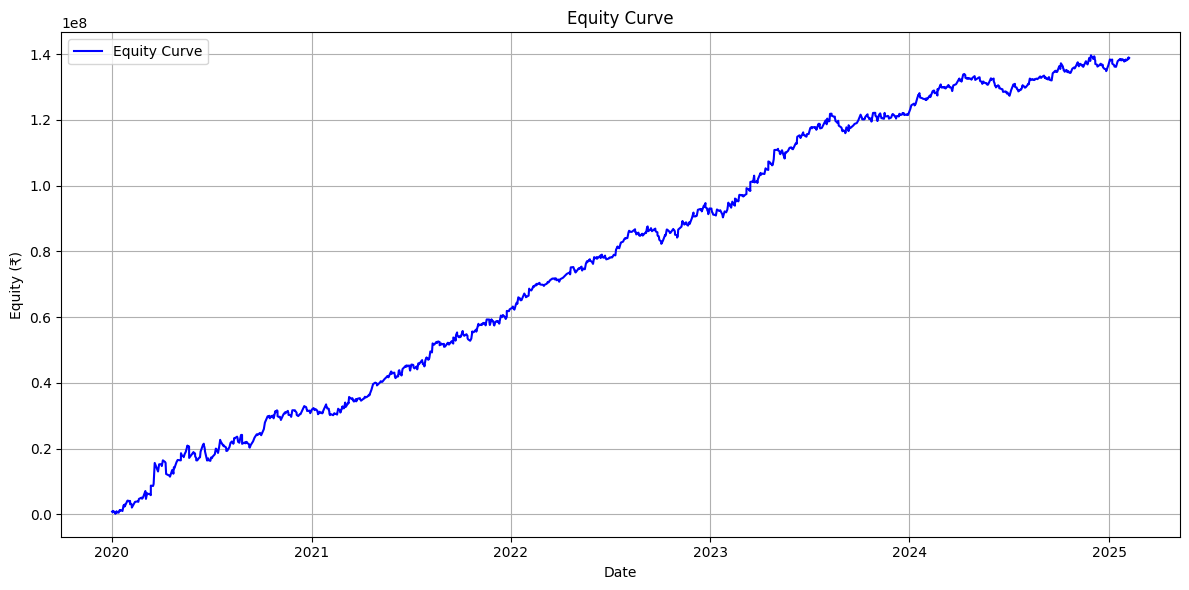

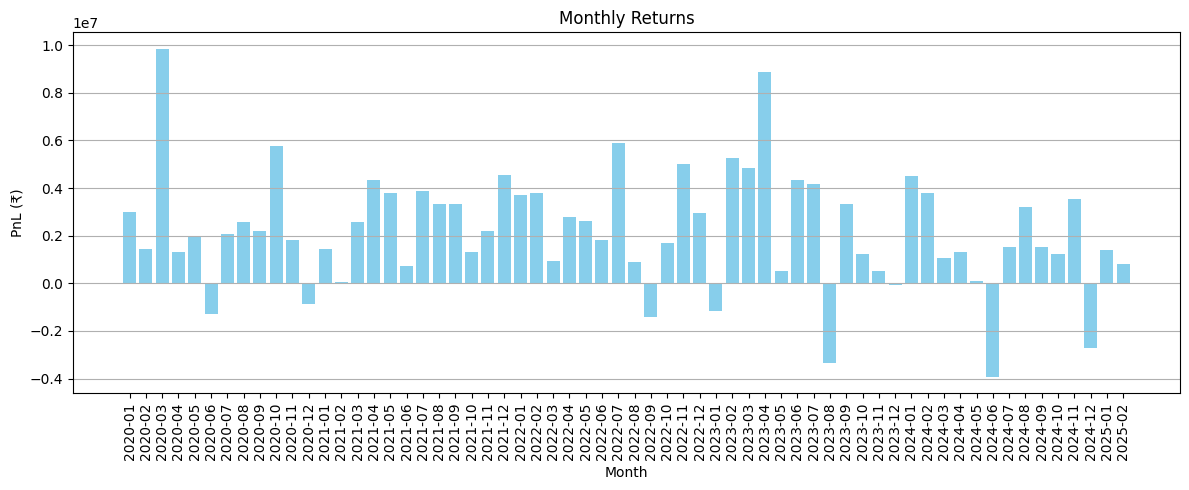

In [11]:
import matplotlib.pyplot as plt

# === Monthly Returns ===
trades_df["month"] = pd.to_datetime(trades_df["exit_time"]).dt.to_period("M")
monthly_returns = trades_df.groupby("month")["pnl_amount"].sum()
monthly_returns_df = monthly_returns.to_frame().reset_index()
monthly_returns_df.columns = ["Month", "Monthly PnL (₹)"]


# === Plot Equity Curve ===
plt.figure(figsize=(12, 6))
plt.plot(trades_df["exit_time"], trades_df["equity"], label="Equity Curve", color="blue")
plt.title("Equity Curve")
plt.xlabel("Date")
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Monthly Returns
plt.figure(figsize=(12, 5))
plt.bar(monthly_returns_df["Month"].astype(str), monthly_returns_df["Monthly PnL (₹)"], color='skyblue')
plt.title("Monthly Returns")
plt.xlabel("Month")
plt.ylabel("PnL (₹)")
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.tight_layout()
plt.show()